# About Dataset
---
Taken from data description: "In this dataset, you are provided over a hundred variables describing attributes of life insurance applicants. The task is to predict the "Response" variable for each Id in the test set. "Response" is an ordinal measure of risk that has 8 levels."

Things to note:
- The problem is an ordinal (ordered) multiclass classification problem
- The performance is measured by a submitted test set on Kaggle using a quadratic weighted kappa. This is just a measure of agreement between two classes.
- The dataset does not say the names of the 8 classes, so I dig deeper online and find the likely classifications that 0-8 corresponds to.

### Variables
---
- Id | A unique identifier associated with an application.
- Product_Info_1-7 | A set of normalized variables relating to the product applied for
- Ins_Age | Normalized age of applicant
- Ht | Normalized height of applicant
- Wt | Normalized weight of applicant
- BMI | Normalized BMI of applicant
- Employment_Info_1-6 | A set of normalized variables relating to the employment history of the applicant.
- InsuredInfo_1-6 | A set of normalized variables providing information about the applicant.
- Insurance_History_1-9	| A set of normalized variables relating to the insurance history of the applicant.
- Family_Hist_1-5 | A set of normalized variables relating to the family history of the applicant.
- Medical_History_1-41 | A set of normalized variables relating to the medical history of the applicant.
- Medical_Keyword_1-48 | A set of dummy variables relating to the presence of/absence of a medical keyword being associated with the application.
- Response | This is the target variable, an ordinal variable relating to the final decision associated with an application

## Imports

In [1]:
#exploration libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
from scipy.stats import norm, skew
%matplotlib inline

#modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.optimize import fmin_powell
from ml_metrics import quadratic_weighted_kappa

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')

## Data Exploration

In [3]:
train.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 128 entries, Id to Response
dtypes: float64(18), int64(109), object(1)
memory usage: 58.0+ MB


In [5]:
train.describe()

,Id,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,...,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,39507.211515,1.026355,24.415655,0.328952,2.006955,2.673599,1.043583,0.405567,0.707283,0.292587,...,0.056954,0.010054,0.045536,0.010710,0.007528,0.013691,0.008488,0.019905,0.054496,5.636837
std,22815.883089,0.160191,5.072885,0.282562,0.083107,0.739103,0.291949,0.197190,0.074239,0.089037,...,0.231757,0.099764,0.208479,0.102937,0.086436,0.116207,0.091737,0.139676,0.226995,2.456833
min,2.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19780.000000,1.000000,26.000000,0.076923,2.000000,3.000000,1.000000,0.238806,0.654545,0.225941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,39487.000000,1.000000,26.000000,0.230769,2.000000,3.000000,1.000000,0.402985,0.709091,0.288703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,59211.000000,1.000000,26.000000,0.487179,2.000000,3.000000,1.000000,0.567164,0.763636,0.345188,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
max,79146.000000,2.000000,38.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000


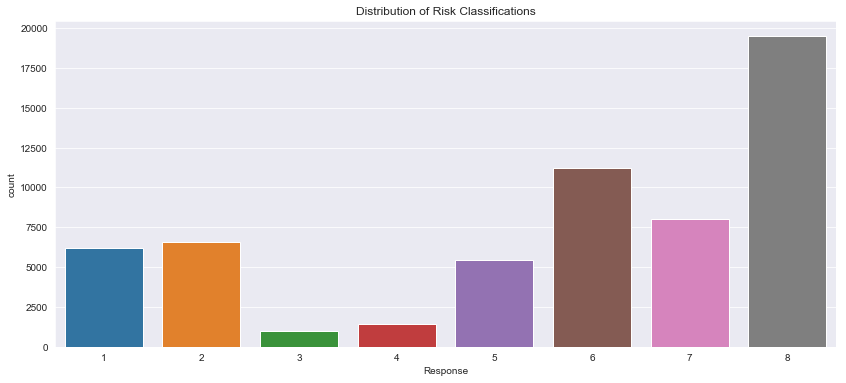

In [6]:
plt.figure(figsize=(14,6))
plt.title('Distribution of Risk Classifications')
sns.countplot(train['Response'])

In [7]:
#count and percentages of each class
print('counts\n' + str(train['Response'].value_counts())+\
      '\n\npercentages\n'+ str(train['Response'].value_counts()/len(train)))

counts
8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: Response, dtype: int64

percentages
8    0.328203
6    0.189168
7    0.135178
2    0.110338
1    0.104528
5    0.091477
4    0.024048
3    0.017059
Name: Response, dtype: float64


I did some digging on Prudential's underwriting and found their health classes are listed as follows: Preferred best, Preferred non-tobacco, non-smoker plus, non-smoker, preferred smoker, smoker, and substandard table scores. It would make sense that the two smoking categories are 3 and 4 since these are the least populated classifications. I will test this theory later in my analysis. Here are the underwriting guidelines:
<img src='prudential_1.png'>
<img src='prudential_2.png'>

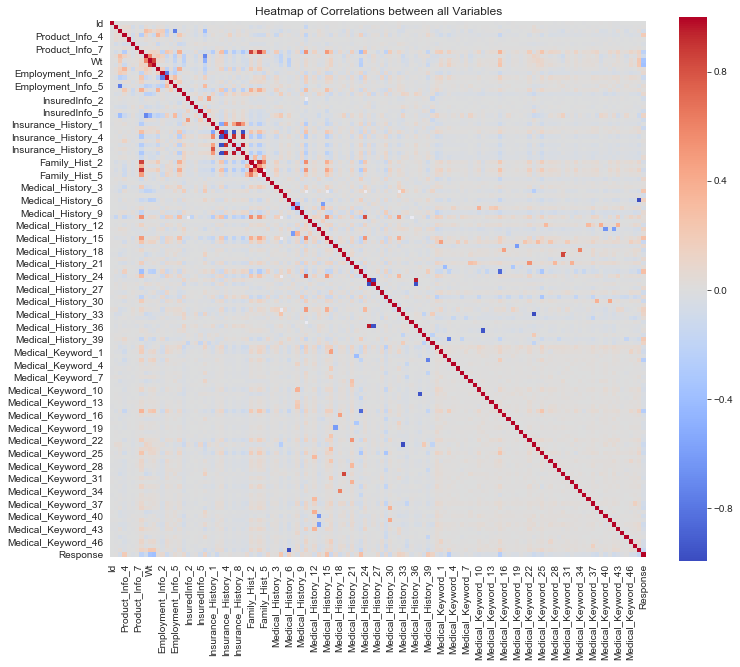

In [8]:
#correlation matrix
plt.figure(figsize=(12,10))
plt.title('Heatmap of Correlations between all Variables')
sns.heatmap(train.corr(), square=True, cmap='coolwarm')

A few variables seem to have multicollinearity, but not enough to warrant more investigation or correction. A tiny percent of variables is unlikely to cause any performance issues for the model.

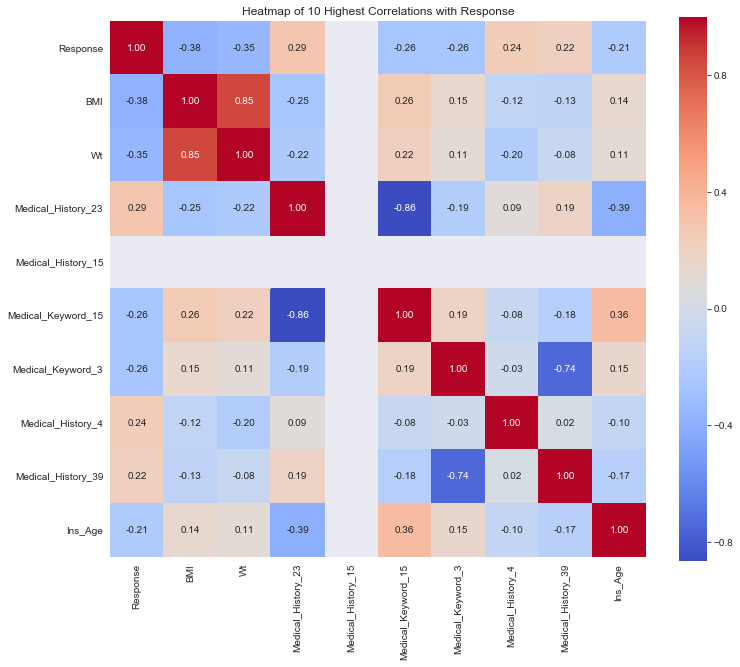

In [9]:
plt.figure(figsize=(12,10))
plt.title('Heatmap of 10 Highest Correlations with Response')
#selects 10 columns with highest correlation with 'SalePrice'
cols = abs(train.corr()).nlargest(10, 'Response')['Response'].index

#creates correlation matrix
#transpose values due to mix of quantitative and categorical data
cm = np.corrcoef(train[cols].values.T)
sns.heatmap(cm, square=True, annot=True, fmt='.2f', 
            yticklabels=cols.values, xticklabels=cols.values, cmap='coolwarm')

BMI and weight columns are the most predictive of risk classification followed by Medical_History columns

Text(0.5,1,'Insurance Age')

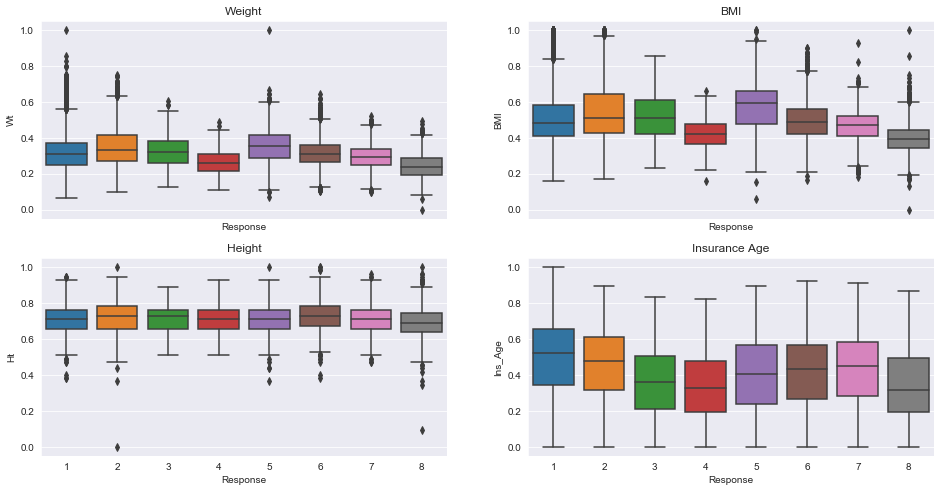

In [10]:
#Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)

ax1 = sns.boxplot(x='Response',y='Wt',data=train,ax=axes[0,0])
ax1.set_title('Weight')

ax2 = sns.boxplot(x='Response',y='BMI',data=train,ax=axes[0,1])
ax2.set_title('BMI')

ax3 = sns.boxplot(x='Response',y='Ht',data=train,ax=axes[1,0])
ax3.set_title('Height')

ax4 = sns.boxplot(x='Response',y='Ins_Age',data=train,ax=axes[1,1])
ax4.set_title('Insurance Age')

The data does not look ordered at first glance. It seems that 1 and 2 are most likely the highest risk classes, and 3 and 4 are smoking classes. The most likely explanation is that 1 is the highest risk and 8 is the lowest. This makes sense due to the dips in popularity at 3 and 4 indicating smoking classes which aligns with Prudential's underwriting classes.

## Deanonymized Prudential Classifications (most likely)
---
1. Substandard Smoker
2. Substandard Non-smoker
3. Smoker
4. Preferred Smoker
5. Non-smoker
6. Non-smoker Plus
7. Preferred Non-tobacco
8. Preferred Best

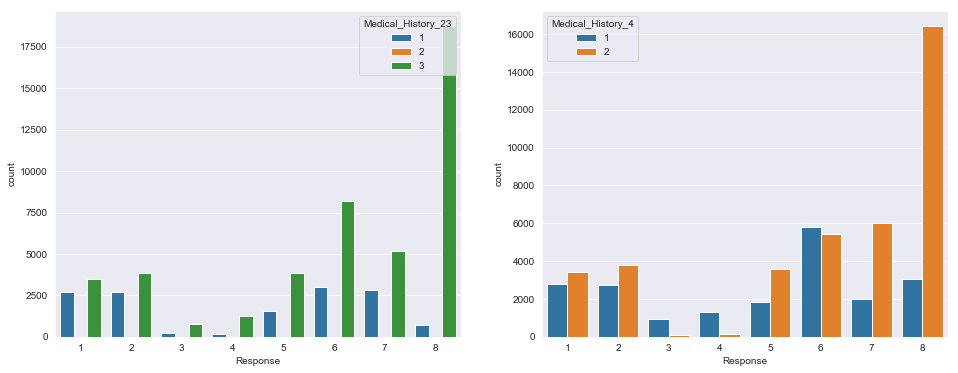

In [11]:
#Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

ax1 = sns.countplot(x='Response',hue='Medical_History_23',data=train,ax=axes[0])
ax2 = sns.countplot(x='Response',hue='Medical_History_4',data=train,ax=axes[1])

In [12]:
#the continuous columns given on the data description page
CONTINUOUS_COLUMNS = ["Product_Info_4", "Ins_Age", "Ht", "Wt", "BMI",
                      "Employment_Info_1", "Employment_Info_4", "Employment_Info_6",
                      "Insurance_History_5", "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5"]
continuous_data = train[CONTINUOUS_COLUMNS]

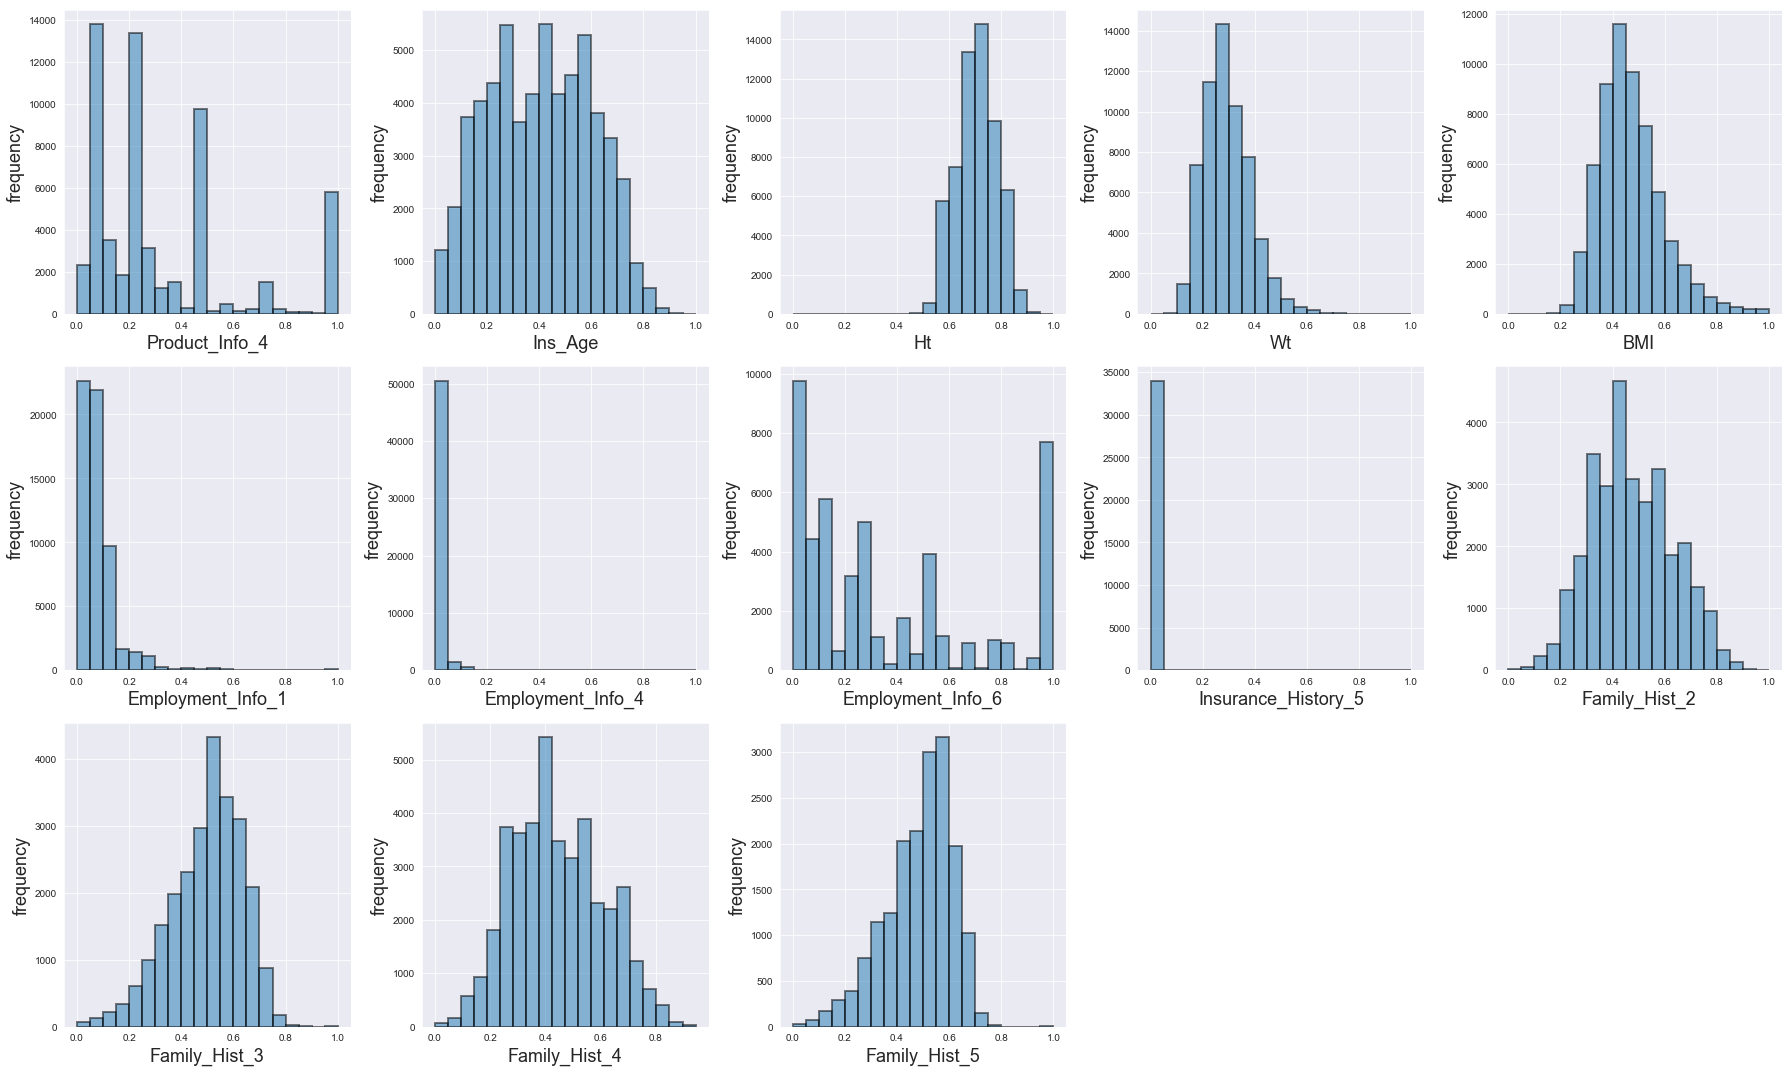

In [13]:
#display continuous data
def plot_histgrams(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        X = data[col].dropna()
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.hist(X, bins=20, alpha=0.5, \
                 edgecolor="black", linewidth=2.0)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_histgrams(continuous_data)

The data description claims that the data is already normalized, and these plots look normal enough for modeling.

In [14]:
CATEGORICAL_COLUMNS = ["Product_Info_1", "Product_Info_2", "Product_Info_3", "Product_Info_5", "Product_Info_6",\
                       "Product_Info_7", "Employment_Info_2", "Employment_Info_3", "Employment_Info_5", "InsuredInfo_1",\
                       "InsuredInfo_2", "InsuredInfo_3", "InsuredInfo_4", "InsuredInfo_5", "InsuredInfo_6", "InsuredInfo_7",\
                       "Insurance_History_1", "Insurance_History_2", "Insurance_History_3", "Insurance_History_4", "Insurance_History_7",\
                       "Insurance_History_8", "Insurance_History_9", "Family_Hist_1", "Medical_History_3",\
                       "Medical_History_4", "Medical_History_5", "Medical_History_6", "Medical_History_7", "Medical_History_8",\
                       "Medical_History_9", "Medical_History_11", "Medical_History_12", "Medical_History_13", "Medical_History_14",\
                       "Medical_History_16", "Medical_History_17", "Medical_History_18", "Medical_History_19", "Medical_History_20",\
                       "Medical_History_21", "Medical_History_22", "Medical_History_23", "Medical_History_25", "Medical_History_26",\
                       "Medical_History_27", "Medical_History_28", "Medical_History_29", "Medical_History_30", "Medical_History_31",\
                       "Medical_History_33", "Medical_History_34", "Medical_History_35", "Medical_History_36", "Medical_History_37",\
                       "Medical_History_38", "Medical_History_39", "Medical_History_40", "Medical_History_41"]
categorical_data = train[CATEGORICAL_COLUMNS]

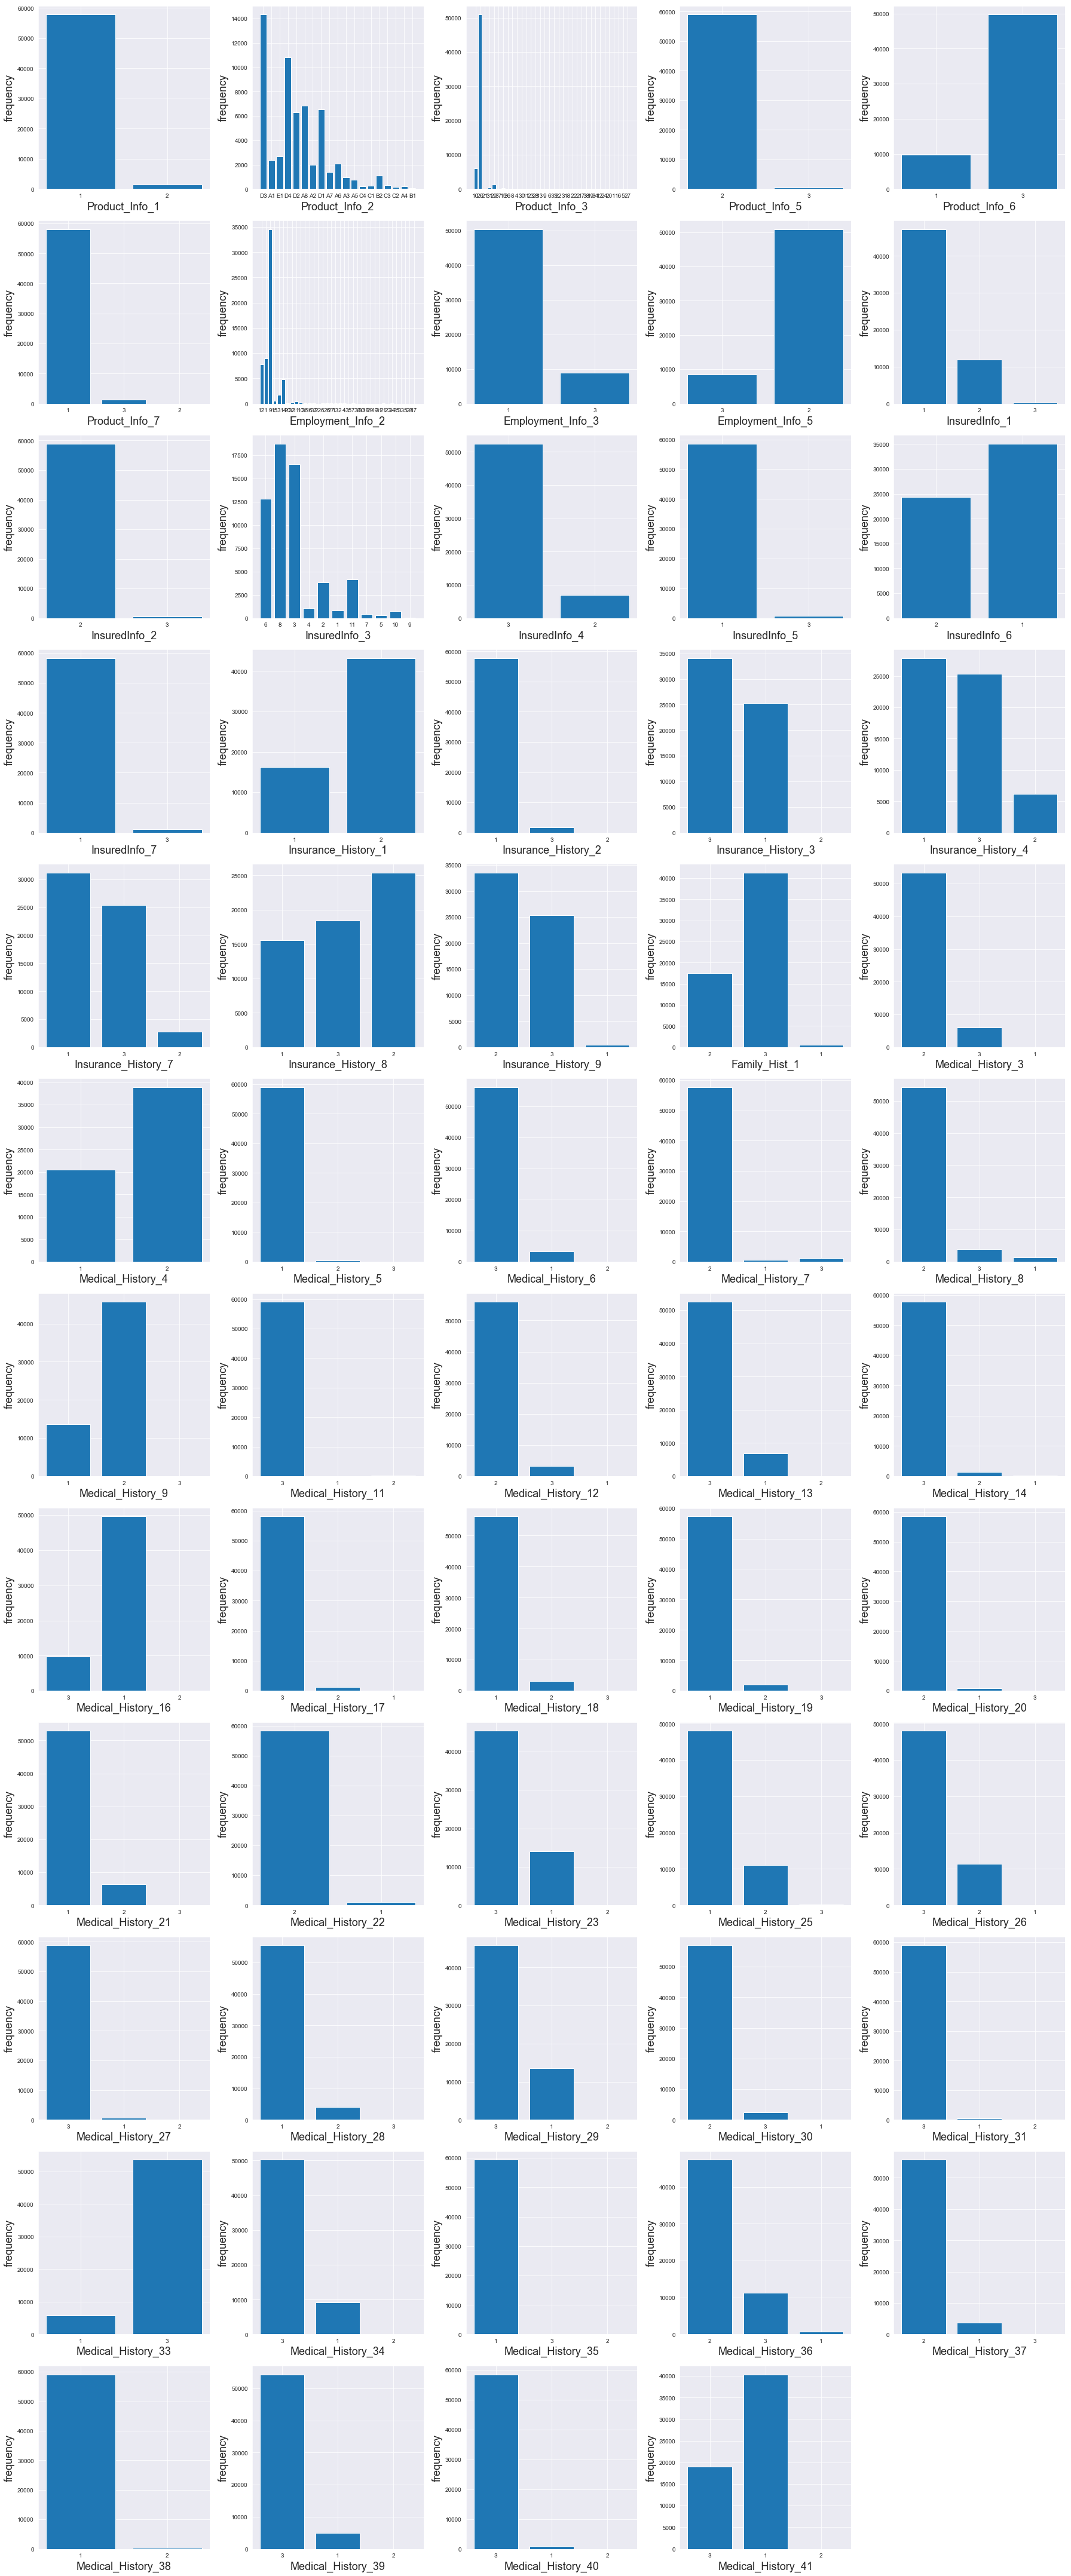

In [15]:
# display categorical data
def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        #counter dictionary for frequency of each unique value in column
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(range(len(keys)), vals, align="center")
        plt.xticks(range(len(keys)), keys)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_categoricals(categorical_data)

## Data Cleaning
---

In [16]:
test = pd.read_csv('test.csv')

In [17]:
#concatenate train and test for feature engineering
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.head()

,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,Family_Hist_1,Family_Hist_2,Family_Hist_3,...,Medical_Keyword_9,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Response,Wt
0,0.323008,0.028,12,1,0.0,3,NaN,2,NaN,0.598039,...,0,1,D3,10,0.076923,2,1,1,8.0,0.148536
1,0.272288,0.000,1,3,0.0,2,0.0018,2,0.188406,NaN,...,0,1,A1,26,0.076923,2,3,1,4.0,0.131799
2,0.428780,0.030,9,1,0.0,2,0.0300,3,0.304348,NaN,...,0,1,E1,26,0.076923,2,3,1,8.0,0.288703
3,0.352438,0.042,9,1,0.0,3,0.2000,3,0.420290,NaN,...,0,1,D4,10,0.487179,2,3,1,8.0,0.205021
4,0.424046,0.027,9,1,0.0,2,0.0500,2,0.463768,NaN,...,0,1,D2,26,0.230769,2,3,1,8.0,0.234310


### Feature Engineering

In [18]:
all_data['Product_Info_2'].head()

0    D3
1    A1
2    E1
3    D4
4    D2
Name: Product_Info_2, dtype: object

I was only having trouble plotting Product_Info_2, so looking closer it has a system of a letter followed by a number for each product. I am going to assume that the letter is a certain category and I'm not sure what the number is, so I'll make features for all of these to feed to the model just in case:

In [19]:
#extract character fron Product_Info_2
all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
#extract number from Product_Info_2
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]
#use factorize to identify distinct values (non-ordinal)
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

In [20]:
#multiply BMI by age
all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

In [21]:
#count total medical keywords from 48 columns
med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Total'] = all_data[med_keyword_columns].sum(axis=1)

In [22]:
#count missing values
all_data['countna'] = all_data.apply(lambda x: sum(x.isnull()),1)

In [23]:
# split train and test
train = all_data[pd.notna(all_data['Response'])]
test = all_data[pd.isna(all_data['Response'])]

### Missing Values

In [24]:
missing = all_data.isnull().sum().sort_values(ascending=False)
pct = (all_data.isnull().sum()/all_data.isnull().count()*100).sort_values(ascending=False)
#creates dataframe with missing and pct missing
miss_data = pd.concat([missing, pct], axis=1, keys=['Missing','Percent'])
#shows columns with missing values
miss_data[miss_data['Missing']>0]

,Missing,Percent
Medical_History_10,78388,99.042276
Medical_History_32,77688,98.157835
Medical_History_24,74165,93.706568
Medical_History_15,59460,75.126981
Family_Hist_5,55435,70.041442
Family_Hist_3,45305,57.242312
Family_Hist_2,38536,48.689763
Insurance_History_5,33501,42.328102
Family_Hist_4,25861,32.675056
Response,19765,24.972835


In [25]:
#drop columns with >90% data missing
all_data.drop(['Medical_History_10','Medical_History_24','Medical_History_32'],
              axis=1,inplace=True)

Evaluate non-dropped columns with <15% missing info:

In [26]:
all_data['Employment_Info_4'].describe()

count    70230.000000
mean         0.006340
std          0.033368
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Employment_Info_4, dtype: float64

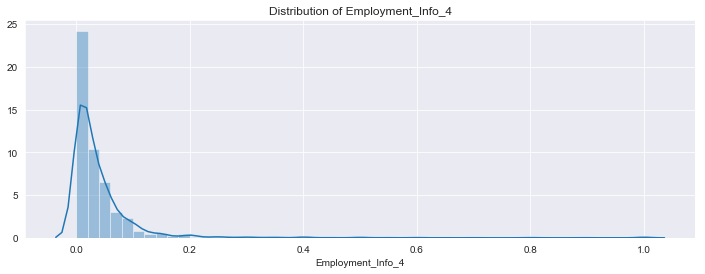

In [27]:
plt.figure(figsize=(12,4))
plt.title('Distribution of Employment_Info_4')
sns.distplot(all_data[all_data['Employment_Info_4']>0]['Employment_Info_4'])

In [28]:
all_data['Employment_Info_1'].describe()

count    79124.000000
mean         0.077930
std          0.082746
min          0.000000
25%          0.035000
50%          0.060000
75%          0.100000
max          1.000000
Name: Employment_Info_1, dtype: float64

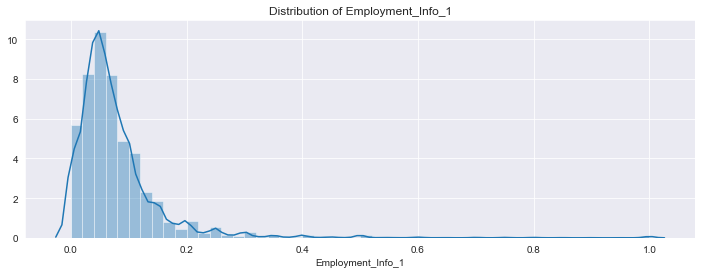

In [29]:
plt.figure(figsize=(12,4))
plt.title('Distribution of Employment_Info_1')
sns.distplot(all_data[all_data['Employment_Info_1']>=0]['Employment_Info_1'])

In [30]:
#impute missing values with median
for col in ('Employment_Info_1','Employment_Info_4'):
    all_data[col] = all_data[col].fillna(all_data[col].median())

In [31]:
#use -1 as placeholder for remaining missing values
all_data.fillna(-1, inplace=True)

In [32]:
#split train and test
train = all_data[all_data['Response']>0]
test = all_data[all_data['Response']<1]

## Modeling
---
### Without Optimization on Validation Set
I chose 4 models: XGBoost, ridge classifier, One vs. Rest logistic regression, and random forest because these are popular methods for solving multiclass classification problems. I then benchmark these basic models on a train/validation split to pick a model to optimize.

In [33]:
y = train['Response']
X = train.drop(['Response','Id'],axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
xgbmodel = XGBClassifier(objective='reg:linear')
#xgbmodel = XGBClassifier(objective='multi:softmax')
xgbmodel.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [37]:
xgb_pred = xgbmodel.predict(X_test)
print(accuracy_score(y_test,xgb_pred))

0.5714405994779826


In [38]:
rcmodel = RidgeClassifierCV()
rcmodel.fit(X_train,y_train)

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None,
         cv=None, fit_intercept=True, normalize=False, scoring=None,
         store_cv_values=False)

In [39]:
rc_pred = rcmodel.predict(X_test)
print(accuracy_score(y_test,rc_pred))

0.470404984423676


In [40]:
logmodel = LogisticRegression(multi_class='ovr')
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [41]:
log_pred = logmodel.predict(X_test)
print(accuracy_score(y_test,log_pred))

0.5001262945188178


In [42]:
rfmodel = RandomForestClassifier()
rfmodel.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
rf_pred = rfmodel.predict(X_test)
print(accuracy_score(y_test,rf_pred))

0.4998737054811821


In [44]:
print('Accuracies without optimization\n-------------------------------')
print('XGBoost: ' + str("{0:.3f}".format(accuracy_score(y_test,xgb_pred))))
print('Logistic Regression: ' + str("{0:.3f}".format(accuracy_score(y_test,log_pred))))
print('Random Forest: ' + str("{0:.3f}".format(accuracy_score(y_test,rf_pred))))
print('Ridge Classifier: ' + str("{0:.3f}".format(accuracy_score(y_test,rc_pred))))

Accuracies without optimization
-------------------------------
XGBoost: 0.571
Logistic Regression: 0.500
Random Forest: 0.500
Ridge Classifier: 0.470


### Model Optimization
---
XGBoost performed the best by far without optimization compared to other multiclass classification techniques. I am using a linear XGBoost method due to the data being ordinal, and giving similar performance to an XGBClassifier. This gives me the advantage of setting offsets (essentially cutoffs for each class) to optimize classification compared to a classification method that treats each class as discrete.

In [45]:
def eval_wrapper(yhat, y):  
    """
    This method takes y predictions and actual y as input and returns a 
    quadratic weighted kappa score (metric used for competition, similar to accuracy)
    """
    y = np.array(y) #
    y = y.astype(int) #fix response datatype
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int) 
    return quadratic_weighted_kappa(yhat, y)

def score_offset(data, bin_offset, sv):
    """
    This method assigns a score to a specific offset to be used for optimization.
    I use this function to assign many offset scores and uses the fmin_powell function
    to select the best offset for a given class
    """
    # data has format of prediction=0, offset prediction=1, actual label=2
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = eval_wrapper(data[1], data[2])
    return score

def apply_offsets(data, offsets):
    """
    This method applies the chosen offset from fmin_powell function to each of the 8 classes
    """
    for j in range(8):
        data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j]
    return data

In [46]:
# convert data to a dense matrix for faster XGBoost processing times
xgtrain = xgb.DMatrix(train.drop(['Id','Response'],axis=1), train['Response'].values, missing=-1)
xgtest = xgb.DMatrix(test.drop(['Id','Response'],axis=1), label=test['Response'].values, missing=-1)

In [47]:
#parameters taken from high-performing Kaggle kernel
param_lst = [('objective', 'reg:linear'),
             ('eta', 0.05),
             ('min_child_weight', 240),
             ('subsample', 0.9),
             ('colsample_bytree', 0.67),
             ('silent', 1),
             ('max_depth', 6)]

In [48]:
xgbmodel = xgb.train(param_lst, xgtrain, num_boost_round=800)

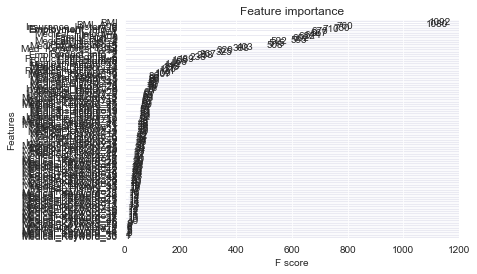

In [49]:
xgb.plot_importance(xgbmodel)

In [50]:
#get predictions
train_preds = xgbmodel.predict(xgtrain, ntree_limit=xgbmodel.best_iteration)
test_preds = xgbmodel.predict(xgtest, ntree_limit=xgbmodel.best_iteration)

print('Train score is:', eval_wrapper(train_preds, train['Response'])) 

Train score is: 0.6643461307959865


In [51]:
#train offsets 
offsets = np.array([0.1, -1, -2, -1, -0.8, 0.02, 0.8, 1])
offset_preds = np.vstack((train_preds, train_preds, train['Response'].values))
offset_preds = apply_offsets(offset_preds, offsets)
opt_order = [6,4,5,3]
for j in opt_order:
    train_offset = lambda x: -score_offset(offset_preds, x, j) * 100
    offsets[j] = fmin_powell(train_offset, offsets[j], disp=False)

print('Offset Train score is:', eval_wrapper(offset_preds[1], train['Response'])) 

Offset Train score is: 0.7149862745862023


In [52]:
#apply offsets to test data
data = np.vstack((test_preds, test_preds, test['Response'].values))
data = apply_offsets(data, offsets)
xgb_pred = np.round(np.clip(data[1], 1, 8)).astype(int)

In [53]:
#create dataframe for Kaggle Submission
df = pd.DataFrame({'Id' : test['Id'], 'Response' : xgb_pred})
df.Response = df.Response.astype('int32')
df.to_csv('xgb_submit_2.csv', index=False)

In [54]:
#Placed 809 out of 2619 with score of 0.66746
#For reference, first place scored 0.67938
df.head()

,Id,Response
59381,1,2
59382,3,7
59383,4,7
59384,9,7
59385,12,8


<img src = 'LI_results.png'>